In [1]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt; plt.ion()
from mpl_toolkits.mplot3d import Axes3D
import time
import math

def tic():
    return time.time()
def toc(tstart, name="Operation"):
    print('%s took: %s sec.\n' % (name,(time.time() - tstart)))


def compute_stereo():
    path_l = 'data/image_left.png'
    path_r = 'data/image_right.png'

    image_l = cv2.imread(path_l, 0)
    image_r = cv2.imread(path_r, 0)

    image_l = cv2.cvtColor(image_l, cv2.COLOR_BAYER_BG2BGR)
    image_r = cv2.cvtColor(image_r, cv2.COLOR_BAYER_BG2BGR)

    image_l_gray = cv2.cvtColor(image_l, cv2.COLOR_BGR2GRAY)
    image_r_gray = cv2.cvtColor(image_r, cv2.COLOR_BGR2GRAY)

    # You may need to fine-tune the variables `numDisparities` and `blockSize` based on the desired accuracy
    stereo = cv2.StereoBM_create(numDisparities=32, blockSize=9) 
    disparity = stereo.compute(image_l_gray, image_r_gray)

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
    ax1.imshow(image_l)
    ax1.set_title('Left Image')
    ax2.imshow(image_r)
    ax2.set_title('Right Image')
    ax3.imshow(disparity, cmap='gray')
    ax3.set_title('Disparity Map')
    plt.show()
    
def read_data_from_csv(filename):
    '''
    INPUT 
    filename        file address

    OUTPUT 
    timestamp       timestamp of each observation
    data            a numpy array containing a sensor measurement in each row
    '''
    data_csv = pd.read_csv(filename, header=None)
    data = data_csv.values[:, 1:]
    timestamp = data_csv.values[:, 0]
    return timestamp, data
    


def mapCorrelation(im, x_im, y_im, vp, xs, ys):
    '''
    INPUT 
    im              the map 
    x_im,y_im       physical x,y positions of the grid map cells
    vp[0:2,:]       occupied x,y positions from range sensor (in physical unit)  
    xs,ys           physical x,y,positions you want to evaluate "correlation" 

    OUTPUT 
    c               sum of the cell values of all the positions hit by range sensor
    '''
    nx = im.shape[0]
    ny = im.shape[1]
    xmin = x_im[0]
    xmax = x_im[-1]
    xresolution = (xmax-xmin)/(nx-1)
    ymin = y_im[0]
    ymax = y_im[-1]
    yresolution = (ymax-ymin)/(ny-1)
    nxs = xs.size
    nys = ys.size
    cpr = np.zeros((nxs, nys))
    for jy in range(0,nys):
        y1 = vp[1,:] + ys[jy] # 1 x 1076
        iy = np.int16(np.round((y1-ymin)/yresolution))
    for jx in range(0,nxs):
        x1 = vp[0,:] + xs[jx] # 1 x 1076
        ix = np.int16(np.round((x1-xmin)/xresolution))
        valid = np.logical_and( np.logical_and((iy >=0), (iy < ny)), \
                                    np.logical_and((ix >=0), (ix < nx)))
        cpr[jx,jy] = np.sum(im[ix[valid],iy[valid]])
    return cpr


def bresenham2D(sx, sy, ex, ey):
    '''
    Bresenham's ray tracing algorithm in 2D.
    Inputs:
      (sx, sy)	start point of ray
      (ex, ey)	end point of ray
    '''
    sx = int(round(sx)) 
    sy = int(round(sy))
    ex = int(round(ex))
    ey = int(round(ey))
    dx = abs(ex-sx)
    dy = abs(ey-sy)
    steep = abs(dy)>abs(dx)
    if steep:
        dx,dy = dy,dx # swap 

    if dy == 0:
        q = np.zeros((dx+1,1))
    else:
        q = np.append(0,np.greater_equal(np.diff(np.mod(np.arange( np.floor(dx/2), -dy*dx+np.floor(dx/2)-1,-dy),dx)),0))
    if steep:
        if sy <= ey:
            y = np.arange(sy,ey+1)
        else:
            y = np.arange(sy,ey-1,-1)
        if sx <= ex:
            x = sx + np.cumsum(q)
        else:
            x = sx - np.cumsum(q)
    else:
        if sx <= ex:
            x = np.arange(sx,ex+1)
        else:
            x = np.arange(sx,ex-1,-1)
        if sy <= ey:
            y = sy + np.cumsum(q)
        else:
            y = sy - np.cumsum(q)
    return np.vstack((x,y))
    

def test_bresenham2D():
    import time
    sx = 0
    sy = 1
    print("Testing bresenham2D...")
    r1 = bresenham2D(sx, sy, 10, 5)
    r1_ex = np.array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9,10],[1,1,2,2,3,3,3,4,4,5,5]])
    r2 = bresenham2D(sx, sy, 9, 6)
    r2_ex = np.array([[0,1,2,3,4,5,6,7,8,9],[1,2,2,3,3,4,4,5,5,6]])	
    if np.logical_and(np.sum(r1 == r1_ex) == np.size(r1_ex),np.sum(r2 == r2_ex) == np.size(r2_ex)):
        print("...Test passed.")
    else:
        print("...Test failed.")

    # Timing for 1000 random rays
    num_rep = 1000
    start_time = time.time()
    for i in range(0,num_rep):
        x,y = bresenham2D(sx, sy, 500, 200)
    print("1000 raytraces: --- %s seconds ---" % (time.time() - start_time))


def test_mapCorrelation():
    _, lidar_data = read_data_from_csv('/Users/orish/wi22/ece276/ECE276A_PR2/code/data/sensor_data/lidar.csv')
    angles = np.linspace(-5, 185, 286) / 180 * np.pi
    ranges = lidar_data[0, :]

    # take valid indices
    indValid = np.logical_and((ranges < 80),(ranges> 0.1))
    ranges = ranges[indValid]
    angles = angles[indValid]

    # init MAP
    MAP = {}
    MAP['res']   = 0.1 #meters
    MAP['xmin']  = -50  #meters
    MAP['ymin']  = -50
    MAP['xmax']  =  50
    MAP['ymax']  =  50 
    MAP['sizex']  = int(np.ceil((MAP['xmax'] - MAP['xmin']) / MAP['res'] + 1)) #cells
    MAP['sizey']  = int(np.ceil((MAP['ymax'] - MAP['ymin']) / MAP['res'] + 1))
    MAP['map'] = np.zeros((MAP['sizex'],MAP['sizey']),dtype=np.int8) #DATA TYPE: char or int8

    #import pdb
    #pdb.set_trace()

    # xy position in the sensor frame
    xs0 = ranges*np.cos(angles)
    ys0 = ranges*np.sin(angles)

    # convert position in the map frame here 
    Y = np.stack((xs0,ys0))

    # convert from meters to cells
    xis = np.ceil((xs0 - MAP['xmin']) / MAP['res'] ).astype(np.int16)-1
    yis = np.ceil((ys0 - MAP['ymin']) / MAP['res'] ).astype(np.int16)-1

    # build an arbitrary map 
    indGood = np.logical_and(np.logical_and(np.logical_and((xis > 1), (yis > 1)), (xis < MAP['sizex'])), (yis < MAP['sizey']))
    MAP['map'][xis[indGood],yis[indGood]]=1

    x_im = np.arange(MAP['xmin'],MAP['xmax']+MAP['res'],MAP['res']) #x-positions of each pixel of the map
    y_im = np.arange(MAP['ymin'],MAP['ymax']+MAP['res'],MAP['res']) #y-positions of each pixel of the map

    x_range = np.arange(-0.4,0.4+0.1,0.1)
    y_range = np.arange(-0.4,0.4+0.1,0.1)



    print("Testing map_correlation with {}x{} cells".format(MAP['sizex'],MAP['sizey']))
    ts = tic()
    c = mapCorrelation(MAP['map'],x_im,y_im,Y,x_range,y_range)
    print(c)
    toc(ts,"Map Correlation")

    c_ex = np.array([[ 4.,  6.,  6.,  5.,  8.,  6.,  3.,  2.,  0.],
                   [ 7.,  5., 11.,  8.,  5.,  8.,  5.,  4.,  2.],
                   [ 5.,  7., 11.,  8., 12.,  5.,  2.,  1.,  5.],
                   [ 6.,  8., 13., 66., 33.,  4.,  3.,  3.,  0.],
                   [ 5.,  9.,  9., 63., 55., 13.,  5.,  7.,  4.],
                   [ 1.,  1., 11., 15., 12., 13.,  6., 10.,  7.],
                   [ 2.,  5.,  7., 11.,  7.,  8.,  8.,  6.,  4.],
                   [ 3.,  6.,  9.,  8.,  7.,  7.,  4.,  4.,  3.],
                   [ 2.,  3.,  2.,  6.,  8.,  4.,  5.,  5.,  0.]])

    if np.sum(c==c_ex) == np.size(c_ex):
        print("...Test passed.")
    else:
        print("...Test failed. Close figures to continue tests.")	

    #plot original lidar points
    fig1 = plt.figure()
    plt.plot(xs0,ys0,'.k')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Laser reading")
    plt.axis('equal')

    #plot map
    fig2 = plt.figure()
    plt.imshow(MAP['map'],cmap="hot");
    plt.title("Occupancy grid map")

    #plot correlation
    fig3 = plt.figure()
    ax3 = fig3.gca(projection='3d')
    X, Y = np.meshgrid(np.arange(0,9), np.arange(0,9))
    ax3.plot_surface(X,Y,c,linewidth=0,cmap=plt.cm.jet, antialiased=False,rstride=1, cstride=1)
    plt.title("Correlation coefficient map")

    plt.show()
  
  
def show_lidar(t):
    _, lidar_data = read_data_from_csv('/Users/orish/wi22/ece276/ECE276A_PR2/code/data/sensor_data/lidar.csv')
    angles = np.linspace(-5, 185, 286) / 180 * np.pi
    ranges = lidar_data[t, :]
    plt.figure()
    ax = plt.subplot(111, projection='polar')
    ax.plot(angles, ranges)
    ax.set_rmax(80)
    ax.set_rticks([0.5, 1, 1.5, 2])  # fewer radial ticks
    ax.set_rlabel_position(-22.5)  # get radial labels away from plotted line
    ax.grid(True)
    ax.set_title("Lidar scan data", va='bottom')
    plt.show()

In [2]:
# if __name__ == '__main__':
    
#     #compute_stereo()
#     #show_lidar()
#     #test_mapCorrelation()
#     #test_bresenham2D()
#     #show_lidar(100)

In [3]:
def new_csv():
    
    fol1 = '/Users/orish/wi22/ece276/ECE276A_PR2/code/data/sensor_data'
    
    file1 = fol1 + '/fog.csv'
    fog_t, fog_d = read_data_from_csv(file1)
    
    file2 = fol1 + '/encoder.csv'
    encod_t, encod_d = read_data_from_csv(file2)
    
    x = np.zeros(6)
    increment = 0
    for t in range(len(encod_t)-1):
        temp = 0
        temp_t = 0
        counter = 0
        for i in range(25):
            temp+=fog_d[increment+t+i]
            counter = i
            temp_t = fog_t[increment+t+i]
            if fog_t[increment+t+i] >= encod_t[t]:
                break
        increment += counter
        tim = (temp_t + encod_t[t])/2
        new = np.hstack((tim,np.hstack((temp,encod_d[t+1]-encod_d[t]))))
        x = np.vstack((x,new))
    
    pd.DataFrame(x).to_csv(fol1 +'/intermediate_sync.csv',header = False, index = False)

#file = new_csv()

'''
Need to change...data is missing
'''
def new_csv_full():
    
    fol1 = '/Users/orish/wi22/ece276/ECE276A_PR2/code/data/sensor_data'
    
    file1 = fol1 + '/intermediate_sync.csv'
    a, b = read_data_from_csv(file1)

    file2 = fol1 + '/lidar.csv'
    lidar_t, lidar_d = read_data_from_csv(file2)

    increment1 = 0
    increment2 = 0

    x = np.zeros((200000,(len(b[1,:])+len(lidar_d[1,:])+1)))
    l = 0
    for t in range(min([len(a),len(lidar_t)])-1):
        if a[t]<lidar_t[t]:
            temp = 0
            temp_t = 0
            counter1 = 0
            for i in range(25):
                temp+=b[increment1+t+i]
                counter1 = i
                temp_t = a[increment1+t+i]
                if a[increment1+t+i] >= lidar_t[t]:
                    break
            increment1 += counter1
            tim = (temp_t + lidar_t[t])/2
            x[t][0] = tim
            x[t][1:] = np.hstack((temp, lidar_d[t]))
            l+=1

        else:
            temp = 0
            temp_t = 0
            counter2 = 0
            for i in range(25):
                temp = lidar_d[increment2+t+i]
                counter = i
                temp_t = lidar_t[increment2+t+i]
                if lidar_t[increment2+t+i] >= a[t]:
                    break
            increment2 += counter2
            tim = (temp_t + a[t])/2
            x[t][0] = tim
            x[t][1:] = np.hstack((b[t],temp))
            l+=1
    ans = x[:l][:]
    pd.DataFrame(ans).to_csv(fol1 +'/full_sync.csv',header = False, index = False)
    
#ans = new_csv_full()

In [4]:
def cumangles():
    fol1 = '/Users/orish/wi22/ece276/ECE276A_PR2/code/data/sensor_data'
    file1 = fol1 + '/full_sync.csv'
    a, b = read_data_from_csv(file1)
    
    for i in range(1,len(a)):
        b[i][0:3] = b[i][0:3]+b[i-1][0:3]
        a[i-1] = a[i]-a[i-1]
    
    ans = np.hstack((np.array(a).reshape(len(a),1),np.array(b)))
        
    pd.DataFrame(ans).to_csv(fol1 +'/cummulative_angles.csv',header = False, index = False)
    
def tau():
    fol1 = '/Users/orish/wi22/ece276/ECE276A_PR2/code/data/sensor_data'
    file1 = fol1 + '/full_sync.csv'
    a, b = read_data_from_csv(file1)
    
    for i in range(1,len(a)):
        a[i-1] = a[i]-a[i-1]
    
    ans = np.hstack((np.array(a).reshape(len(a),1),np.array(b)))
        
    pd.DataFrame(ans).to_csv(fol1 +'/tau_diffYaw.csv',header = False, index = False)
    
#ans = cumangles()
#ans = tau()

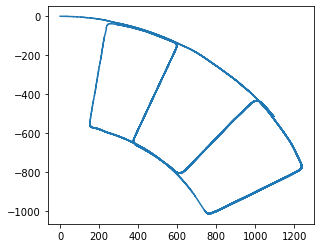

In [5]:
fol1 = '/Users/orish/wi22/ece276/ECE276A_PR2/code/data/sensor_data'
file1 = fol1 + '/cummulative_angles.csv'
a, b = read_data_from_csv(file1)

fog_cumulative = np.zeros((96444, 3))
fog_cumulative = b[:,:3]
diff_enc_l = b[:,3]
diff_enc_r = b[:,4]
rays_deg = b[:,5:]

resol = 4096
l_dia = 0.623479
r_dia = 0.622806

velocity = np.array((l_dia*diff_enc_l*2*np.pi + r_dia*diff_enc_r*2*np.pi)/(2*resol*np.array(a))) #


def cordinates():
    
    x = np.array([0,0])
    t = 0
    for t in range(len(a)-1):
        yaw = fog_cumulative[t][2]
        xn = np.array([a[t]*velocity[t]*np.cos(yaw),a[t]*velocity[t]*np.sin(yaw)])
        x = np.vstack((x,x[t-1]+xn))
    return x

trajectory = cordinates()

def plotpath(trajectory):

    x = [step[0] for step in trajectory[1:]]
    y = [step[1] for step in trajectory[1:]]

    plt.plot(x,y)
    plt.gca().set_aspect("equal")
    plt.show()
        
plotpath(trajectory)

In [6]:
'''
FOG parameters
'''
FOV = 190
start_angle = -5. #degree
end_angle = 185. #degree
resol = 0.666
rrange = 80.
n = int((FOV//resol)+1) # number of rays

vRl = np.array([[0.00130201, 0.796097, 0.605167],
                [0.999999, -0.000419027, -0.00160026],
                [-0.00102038, 0.605169, -0.796097]])
vTl = np.array([0.8349,-0.0126869, 1.76416 ])

'''
functions
'''

def rotation_z(yaw):
    ans = np.array([[np.cos(yaw), -np.sin(yaw), 0],
                    [np.sin(yaw), np.cos(yaw), 0],
                    [0, 0, 1]])
    return ans

def transform(R,T,x):
    '''
    t and x are row vectors
    outpot is also a row vector
    '''
    pose = np.identity(4)
    pose[:3,:3] = R
    pose[:3,3] = T
    x = np.array(x).T
    n = len(x[0,:])
    if len(x[:,0]) == 3:
        x = np.vstack((x,np.ones(n))) #1,4
    #x = np.array(x).T #4,1
    ans = np.matmul(pose,x).T
    return ans #1,4


def angles_array(t):
    '''
    To calculate valid rays and corresponding angles at time t
    '''
    angles = np.linspace(-5, 185, 286) / 180 * np.pi
    rays = rays_deg[t,:]
    indValid = np.logical_and((rays < 75), (rays > 2))
    rays = rays[indValid]
    angles = angles[indValid]
            
    return angles, rays #(n,)
    
def cartesian(t):
    '''
    To calculate cartesian coordinates of end points of valid rays at time t
    '''
    # t - time
    angle,r = angles_array(t) #(n,)
    x = r*np.cos(angle)
    y = r*np.sin(angle)
    z = np.zeros(len(r)) # to make zero z vector
    ans = np.stack((x,y,z), axis=1) #n,3
    return ans

def ray_start(wXv,yaw):
    '''
    coordinates, overall yaw of vehicle wrt world
    '''
    t_len,gg = angles_array(t)
    t_ln = len(t_len)
    Xl = np.tile([0,0,0],(t_ln,1)) 
    vXl = transform(vRl,vTl,Xl)
    wRv = rotation_z(yaw)
    wXl = transform(wRv, wXv, vXl)
    
    return wXl #4, = 1,4 np array

def ray_end(t, wXv,yaw):
    '''
    time for indValid, coordinates, overall yaw of vehicle wrt world
    '''
    Xl = cartesian(t) #n,3 - in in lidar frame
    vXl = transform(vRl,vTl,Xl) # lidar to vehicle
    wRv = rotation_z(yaw)
    wXl = transform(wRv,wXv,vXl) # in world frame
    
    return wXl #n,4

In [7]:
def define_map():
    MAP = {}
    MAP['res'] = 1  # meters
    MAP['xmin'] = -100  # meters
    MAP['ymin'] = -1200
    MAP['xmax'] = 1300
    MAP['ymax'] = 200
    MAP['sizex'] = int(np.ceil((MAP['xmax'] - MAP['xmin']) / MAP['res'] + 1))  # cells along x
    MAP['sizey'] = int(np.ceil((MAP['ymax'] - MAP['ymin']) / MAP['res'] + 1))  # cells along y
    MAP['map'] = np.zeros((MAP['sizex'], MAP['sizey']), dtype=np.float32)  # DATA TYPE: char or int8

    return MAP

def map_updation(t,wXv,yaw):
    '''
    time for indValid, coordinates, overall yaw of vehicle wrt world, MAP
    '''
    xy_start = ray_start(wXv,yaw)
    x_start = xy_start[:,0]
    y_start = xy_start[:,1]

    sx = np.ceil((x_start - MAP['xmin']) / MAP['res']).astype(np.int16)-1
    sy = np.ceil((y_start - MAP['ymin']) / MAP['res']).astype(np.int16)-1

    xy_end = ray_end(t,wXv,yaw)
    x_end = xy_end[:,0]
    y_end = xy_end[:,1]
    ex = np.ceil((x_end - MAP['xmin']) / MAP['res']).astype(np.int16)-1
    ey = np.ceil((y_end - MAP['ymin']) / MAP['res']).astype(np.int16)-1

    for n in range(len(x_end)):
        bresenham_points = bresenham2D(sx[n], sy[n], ex[n], ey[n]) #n can be removed from sx by changing lidar function
        bresenham_points_x = bresenham_points[0, :].astype(np.int16)
        bresenham_points_y = bresenham_points[1, :].astype(np.int16)

        indGood = np.logical_and(np.logical_and(np.logical_and((bresenham_points_x > 1), (bresenham_points_y > 1)), (bresenham_points_x < MAP['sizex'])), (bresenham_points_y < MAP['sizey']))

        ## Update Map

        # decrease log-odds if cell observed free
        MAP['map'][bresenham_points_x[indGood], bresenham_points_y[indGood]] -= np.log(4)

        # increase log-odds if cell observed occupied
        # if ((ex[n] > 1) and (ex[n] < MAP['sizex']) and (ey[n] > 1) and (ey[n] < MAP['sizey'])):
        #     MAP['map'][ex[n], ey[n]] += np.log(4)

    # clip range to prevent over-confidence
    MAP['map'] = np.clip(MAP['map'], -10*np.log(4), 10*np.log(4))

    return MAP

def plot_map(MAP):
    
    # cv2.imshow('map',MAP['map'])
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    # MAP['map']   np.ones((MAP['sizex'], MAP['sizey']), dtype=np.int)*128  # DATA TYPE: char or int8


    plt.imshow(MAP['map'], cmap='gray')
    #plt.plot(sx,300-sy)
    
    plt.title("Deterministic Map")
    plt.xlabel("x grid-cell coordinates")
    plt.ylabel("y grid-cell coordinates")
    plt.savefig("Deterministic_Map.png")
    plt.show()
    
def plot_superimp(x):
    MAP = define_map()
    x = np.array(x)
    sx = np.ceil((x[:,0] - MAP['xmin']) / MAP['res']).astype(np.int16)-1
    sy = np.ceil((x[:,1] - MAP['xmin']) / MAP['res']).astype(np.int16)-1
    return sx,sy

def world2grid(matrix): #filter
    xs0= matrix[0,:]
    ys0= matrix[1,:]
    xis = np.ceil((xs0 - MAP['xmin']) / MAP['res'] ).astype(np.int32)-1
    yis = np.ceil((ys0 - MAP['ymin']) / MAP['res'] ).astype(np.int32)-1

    # build an arbitrary map 
    indGood = np.logical_and(np.logical_and(np.logical_and((xis > 1), (yis > 1)), (xis < MAP['sizex'])), (yis < MAP['sizey']))
    return np.vstack((xis,yis))


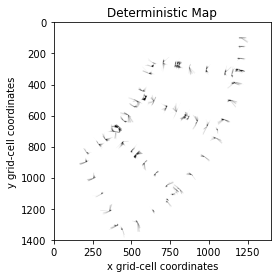

(115864, 2)

In [8]:
x = cordinates()
height = len(x[:,0])
all_wXv = np.zeros((height,3))
all_wXv[:,:2] = x

all_yaw = fog_cumulative[:,2]
MAP = define_map()
#sx,sy = plot_superimp(x)
#rays_deg

for t in range(0,len(a),1000):
    wXv = all_wXv[t]
    yaw = all_yaw[t]

    map_updation(t,wXv,yaw)

plot_map(MAP)
x.shape
    
#deadrecon()

In [9]:
fol_d = '/Users/orish/wi22/ece276/ECE276A_PR2/code/data/sensor_data'
file_d = fol_d + '//tau_diffYaw.csv'
times, others = read_data_from_csv(file_d)
diff_yaw = others[:,2]

In [10]:


def predict(u, t,numParticles): #dont need v and yaw, already inside func as a function of t
    '''
    predicts the next with added noise state at a certain time
    '''
    tau= (times[t])
    
    for i in range (numParticles):
        noisy_yaw = diff_yaw[t]+np.random.normal(0, np.abs(diff_yaw[t]/50))
        
        u[2,i] = u[2,i]+noisy_yaw # use full_sync csv here..as we cant use cumulative theta
        noise_v = velocity[t] + np.random.normal(0, np.abs(velocity[t]/200))
        differential=np.array([noise_v*np.cos(u[2,i]), noise_v*np.sin(u[2,i])])
        differential=np.hstack((differential, np.zeros(1)))
        u[:,i]=u[:,i]+tau*differential
    return u
    

In [11]:
def weight_approximate(MAP, state, weights, t, particle_count): #co relation checker

    # grid cells representing walls with 1
    #map_wall = ((1 - 1 / (1 + np.exp(MAP['map']))) > 0.5).astype(int)
    map_wall = MAP['map']
    x_im = np.arange(MAP['xmin'], MAP['xmax'] + MAP['res'], MAP['res'])  # x index of each pixel on log-odds map
    y_im = np.arange(MAP['ymin'], MAP['ymax'] + MAP['res'], MAP['res'])  # y index of each pixel on log-odds map

    # 9x9 grid around particle
    x_range = np.arange(-4 * MAP['res'], 5 * MAP['res'], MAP['res'])  # x deviation
    y_range = np.arange(-4 * MAP['res'], 5 * MAP['res'], MAP['res'])  # y deviation

    correlation = np.zeros(particle_count)

    for i in range(particle_count):
        # wXv - (3,)
        wXv = [state[0,i],state[1,i],0]
        yaw = state[2,i]
        
        xy_end = ray_end(t,wXv,yaw)
        x_end = xy_end[:,0]
        y_end = xy_end[:,1]
        ex = np.ceil((x_end - MAP['xmin']) / MAP['res']).astype(np.int16)-1
        ey = np.ceil((y_end - MAP['ymin']) / MAP['res']).astype(np.int16)-1
        
        vp = np.stack((ex, ey))

        # calculate correlation
        c = mapCorrelation(map_wall, x_im, y_im,vp,x_range, y_range)

        # find largest correlation
        correlation[i] = np.max(c)

    # update particle weight with softmax function
    d = np.max(correlation)
    beta = np.exp(correlation - d)
    p_h = beta / beta.sum()
    weights *= p_h / np.sum(weights * p_h)

    return state, weights

In [12]:

#     # 9x9 grid around particle
x_range = np.arange(-4 * MAP['res'], 5 * MAP['res'], MAP['res'])  # x deviation
print(x_range)
#     y_range = np.arange(-4 * MAP['res'], 5 * MAP['res'], MAP['res']) 

[-4 -3 -2 -1  0  1  2  3  4]


In [13]:
def resampling(state, weights, particle_count):

    state_new = np.zeros((3, particle_count))
    weights_new = np.tile(1 / particle_count, particle_count).reshape(1, particle_count) #1,n
    j = 0
    weights = weights.reshape(1,particle_count)
    c = weights[0,0]

    for i in range(particle_count):
        z = np.random.uniform(0, 1/particle_count)
        beta = z + i/particle_count  # i=k-1
        while beta > c:
            j += 1
            c += weights[0,j]

        # add to the new set
        state_new[:, i] = state[:, j]

    return state_new, weights_new[0]

In [14]:
def main(numParticles):
    
    weights=np.ones(numParticles)/numParticles #1,4 - particle weight
    u=np.zeros([3,numParticles])
    MAP = define_map()
    
    for t in range(0,len(times),500):
        
        n_u = predict(u, t,numParticles)
        '''
        co-relation
        '''
        state,n_weights = weight_approximate(MAP, n_u, weights ,t, numParticles) # pose_update
        
        best_particle_ind = np.argmax(n_weights)
        best_state = state[:, best_particle_ind]
        '''
        map updation
        '''
        wXv = [best_state[0],best_state[1],0]
        yaw = best_state[2]
        
        MAP = map_updation(t,wXv,yaw)
        '''
        resample
        '''
        u,weights = resampling(state, weights, numParticles)
        
    return MAP

In [21]:
numParticles = 4
# times, others = read_data_from_csv(file_d)
weights=np.ones(numParticles)/numParticles #1,4 - particle weight
u=np.zeros([3,numParticles])
MAP = define_map()
#MAP = map_updation(0,[0,0,0],0)
for t in range(0,1000):
        
        u = predict(u, t,numParticles)
        '''
        co-relation
        '''
        state,n_weights = weight_approximate(MAP, u, weights ,t, numParticles)
        #print(weights)# pose_update
        

        best_particle_ind = np.argmax(n_weights)
        best_state = state[:, best_particle_ind]
        
        '''
        map updation
        '''
        wXv = [best_state[0],best_state[1],0]
        yaw = best_state[2]
        
        MAP = map_updation(t,wXv,yaw)
        '''
        resample
        '''
        u,weights = resampling(state, n_weights, numParticles)
        



In [22]:
# MAP = define_map()
# MAP = map_updation(0,[0,0,0],0)

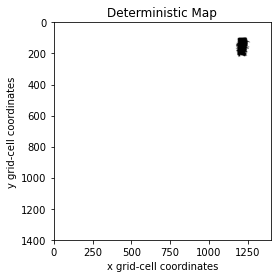

In [23]:
plot_map(MAP)

In [ ]:
print(MAP['map'][200,300])